In standard dropout regularization, one zeros out some fraction of the nodes in each layer and then debiases each layer by normalizing by the fraction of nodes that were retained. In other words, with dropout probability p, each intermediate activation h is replaced by a random variable h' as :
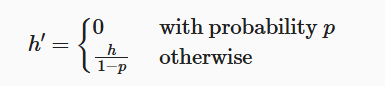


In [5]:
import torch
from torch import nn
from d2l import torch as d2l

Typically, we disable drop out at test time but there are some exceptions:
- some researchers use dropout at test time as a heuristic for estimating the uncertainity of neural network predictions: if the predictions agree across many different dropout outputs, then we might say that the network is more confident.

### Implementation from Scratch

In [6]:
def dropout(X, dropout):
    assert 0 <= dropout <=1
    if dropout == 1: return torch.zeros_like(X)
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / 1 - dropout

#### Defining the model

In [69]:
class DropoutMLP(nn.Module):
    def __init__(self, num_outputs, hidden_1, hidden_2, dropout_1, dropout_2, lr):
        super().__init__()
        self.flatten = nn.Flatten()
        self.lin1 = nn.LazyLinear(hidden_1)
        self.lin2 = nn.LazyLinear(hidden_2)
        self.output = nn.LazyLinear(num_outputs)
        self.relu = nn.ReLU()
        self.dropout_1 = dropout_1
        self.dropout_2 = dropout_2
        self.lr = lr

    def forward(self, X):
        X = self.flatten(X)
        h1 = self.relu(self.lin1(X.reshape(X.shape, -1)))
        h1 = dropout(h1, self.dropout_1)
        h2 = self.relu(self.lin2(h1))
        h2 = dropout(h2, self.dropout_2)
        return (self.output(h2))

#### Training

In [70]:
hparams = {'num_outputs':10, 'hidden_1': 392, 'hidden_2': 186, 'dropout_1':0.3, 'dropout_2':0.35, 'lr': 0.1}

data = d2l.FashionMNIST(batch_size = 256)

In [71]:
model = DropoutMLP(**hparams)

In [72]:
optimizer = torch.optim.SGD(params = model.parameters(), lr = model.lr)

In [73]:
loss = nn.CrossEntropyLoss()

In [74]:
max_epochs = 5
train_dataloader = data.get_dataloader(train=True)
val_dataloader = data.get_dataloader(train=False)

for epoch in range(0,max_epochs):

    train_loss = 0
    test_loss = 0

    for X,y in train_dataloader:
        preds = model(X)
        train_batch_loss = loss(preds, y)
        train_loss += train_batch_loss
        
        optimizer.zero_grad()
        train_batch_loss.backward()

        optimizer.step()

    train_loss /= len(train_dataloader)

    for X,y in val_dataloader:
        with torch.inference_mode():
            preds = model(X)

        test_batch_loss = loss(preds,y)
        test_loss += test_batch_loss

    test_loss /= len(val_dataloader)

    print(f" Epoch: {epoch+1} \n---- Training loss : {train_loss} \n---- Test loss : {test_loss}")
        
        
        

 Epoch: 1 
---- Training loss : 1.4044078588485718 
---- Test loss : 0.8779822587966919
 Epoch: 2 
---- Training loss : 0.7436457872390747 
---- Test loss : 0.6780807971954346
 Epoch: 3 
---- Training loss : 0.6298611760139465 
---- Test loss : 0.6121622323989868
 Epoch: 4 
---- Training loss : 0.5704200863838196 
---- Test loss : 0.5678185224533081
 Epoch: 5 
---- Training loss : 0.5316411852836609 
---- Test loss : 0.5308247804641724


In [75]:
X = torch.randn(784).reshape(1,28,28)
preds = model(X)
print(nn.Softmax(preds))

Softmax(
  dim=tensor([[-0.0976,  2.9442, -0.3801,  2.0186, -1.5511,  2.3888, -1.1724, -0.8870,
           -2.5558, -1.3442]], grad_fn=<AddmmBackward0>)
)


In [61]:
X,y = next(iter(train_dataloader))
X[0].shape

torch.Size([1, 28, 28])

### Concise Implementation

In [86]:
class MLPDropout(d2l.Classifier):
    def __init__(self, num_outputs, hidden_1, hidden_2, dropout_1, dropout_2, lr):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(hidden_1),
            nn.ReLU(),
            nn.Dropout(),
            nn.LazyLinear(hidden_2),
            nn.ReLU(),
            nn.Dropout(),
            nn.LazyLinear(num_outputs)
        )
        self.lr = lr

    def forward(self,X):
        return self.net(X)

In [87]:
concise_model = MLPDropout(**hparams)

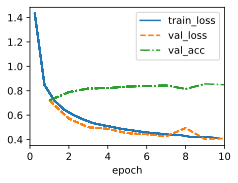

In [88]:
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(concise_model,data)